# Simulation Code

In [ ]:
import jax.numpy as np
import numpy as onp
from jax.lax import cond
from jax import vmap,jit,random,grad,value_and_grad
from functools import partial
from jax.scipy.stats.norm import pdf,cdf,ppf
from bisect import bisect_left as bl
import matplotlib.pyplot as plt


from jax import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans",False)

plt.rcParams["text.usetex"] = True



### For Debugging

In [ ]:

debug = False
if debug: # a non-accelerated version of jax.lax.scan for testing purposes
  def scan(f,c0,xs=None,length = 1):
    if xs is None:
      xs = [None]*length
    c = c0
    ys = []
    for x in xs:
      c,y = f(c,x)
      ys.append(y)
    ds = []
    try:
      _ = iter(ys[0])
      for i in range(len(ys[0])):
        d = []
        for j in range(len(ys)):
          d.append(ys[j][i])
        ds.append(np.array(d))
    except:
      ds = np.array(ys)
    return c,ds

else:
  from jax.lax import scan
  from jax import jit

## Simulation Classes

### Support functions

In [ ]:

def ker(x):
  """
  Standard normal probability density function.

  x - vector of real numbers

  return - real number
  """
  return np.exp(-x@x/2)*((2*np.pi)**(-len(x)/2))

def logker(x,h):
  """
  Natural logarithm of a standard normal probability density function.
  h gives the standard deviation.

  x - vector of real numbers
  h - positive real number

  return - real number
  """
  return -x@x/2/h**2 - len(x)/2*np.log(2*np.pi*h**2)


@jit
def eval_kde(y,xs,h):
  """
  Evalutes a Gaussian kernel density. y is the evaluation point, xs are the
  sample points, and h is the standard deviation of each density at the
  sample points.

  y - real number
  xs - vector of real numbers
  h - positive real number

  return - real number
  """
  logkers = vmap(logker,in_axes = (0,None))(y-xs,h)
  pref = np.max(logkers)
  logkers = logkers - pref
  return np.exp(pref)*np.mean(np.exp(logkers))

@jit
def logpdf(y,xs,h):
  """
  Evalutes the logarithm of the Gaussian kernel density. y is the evaluation point, xs are the
  sample points, and h is the standard deviation of each density at the
  sample points.

  y - real number
  xs - vector of real numbers
  h - positive real number

  return - real number
  """
  logkers = vmap(logker,in_axes = (0,None))(y-xs,h)
  pref = np.max(logkers)
  logkers = logkers - pref
  return pref + np.log(np.mean(np.exp(logkers)))

@jit
def logl(ys,xs,h):
  """
  Evaluates the likelihood function of the vector ys, given the samples xs.
  h is the standard deviation of each of the densities at the sample points.

  ys - vector of real numbers
  xs - vector of real numbers
  h - positive real number

  return - real number
  """
  def sf(s,y):
    s = s + logpdf(y,xs,h)
    return s,None
  S,_ = scan(sf,0.,ys)
  return S


@jit
def entaprx(ys,xs,h,lyCut):
  """
  Aproximates the entropy of the distribution from which xs, and ys are drawn.
  ys are the evaluation points, and sample xs are the points used to build
  the kernel density estimator. h is the standard deviation of each
  of the densities at the sample points. The cut off lyCut is included to avoid
  numerical overflow. Approximation converges as the number of xs and ys goes
  to infinity and lyCut goes to negative infinity.

  ys - vector of real numbers
  xs - vector of real numbers
  h - positive real number
  lyCut - real number

  return - real number
  """
  def sf(s,y):
    l = logpdf(y,xs,h)
    l = cond(np.isinf(l),lambda x: 0.,lambda x: l,None)
    s += l*(1 + np.sign(l-lyCut))/2
    return s,None
  S,_ = scan(sf,0.,ys)
  return -S/len(ys)

@partial(jit,static_argnums = (5,))
def opt(h,xmle,xkde,dh0,scale = 1/np.sqrt(2),nSteps = 100):
  """
  Find the standard deviation h which maximizes the likelihood of the data.
  The likelihood appears concave in h, so we simply line search picking the
  best of (h - dh0,h,h + dh0) at each step.
  h is the initial guess. xkde is used to build the kernel density estimator.
  xmle are the evaluation points of the likelihood. dh0 is the starting step
  size of the optimizer. At each step that h is better than h - dh0 and h + dh0,
  we shrink dh -> scale*dh. nSteps is the number of evaluation steps. Returns
  the best h and final dh.

  h - positive real number
  xmle - vector of real numbers
  xkde - vector of real numbers
  dh0 - positive real number
  scale - real number in (0,1)
  nSteps - positive integer

  return - real number, real number
  """
  def sc(c,n):
    h,v,dh = c
    vp = logl(xmle,xkde,h+dh)
    vm = logl(xmle,xkde,h-dh)
    nh,nv = cond(v < vp,lambda x: (h+dh,vp),lambda x: (h,v),None)
    nh,nv = cond(nv < vm,lambda x: (h-dh,vm),lambda x: (nh,nv),None)
    dh = cond(v == nv,lambda x: dh*scale,lambda x: dh,None)
    return (nh,nv,dh),None
  c,_ = scan(sc,(h,logl(xmle,xkde,h),dh0),None,length = nSteps)
  h,_,dh = c
  return h,dh

def indc(x):
  return 1/2*(1 + np.sign(x))

@jit
def bDiff(x):
  x = x.at[1:].set(x[1:]-x[:-1])
  return x

@jit
def fDiff(x):
  x = x.at[:-1].set(x[1:]-x[:-1])
  x = x.at[-1].set(-x[-1])
  return x

@jit
def diff2(x):
  x0 = x[0]
  x = bDiff(fDiff(x))
  x = x.at[0].set(x[0] - x0)
  return x


@partial(jit,static_argnums = (0,))
def rk4Step(f,x,y,t,dt):
  """
  Fourth order Runge-Kutta method
  """
  kx1,ky1 = f(x,y,t)
  kx2,ky2 = f(x + kx1*dt/2,y + ky1*dt/2,t + dt/2)
  kx3,ky3 = f(x + kx2*dt/2,y + ky2*dt/2,t + dt/2)
  kx4,ky4 = f(x + kx3*dt,y + ky3*dt,t + dt)
  return x + dt/6 *(kx1 + 2*kx2 + 2*kx3 + kx4),y + dt/6 *(ky1 + 2*ky2 + 2*ky3 + ky4)




### Langevin Dynamics

In [ ]:

class Langevin:
  """
  Simulation class to perform Langevin dynamic simulations of the system.
  System parameters can be specified via param0 or param. param is used if
  both are specified. param0 should be used for correct scaling as nMasses
  goes to infinity. ell(t) specifies the external driving, nMasses gives the
  number of free masses in the system.

  param0,param - dictionary "eta" - positive real number (drag coeff)
                            "beta"- positive real number (inverse absolute temperature)
                            "l1"  - positive real number (distance left minimia)
                            "l2"  - positive real number (distance right minimia)
                            "a"   - positive real number (strength of interaction)
  ell - function of a real number
  nMasses - positive integer

  return - None
  """
  def __init__(self,param0 = {"eta":1.,"beta":1.,"l1":1.,"l2":1.5,"a":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    return

  def v(self,x): # pairwise interaction potential
    return self.a*(x**4/4 + (self.l1 - self.l2)*x**3/3 - self.l1*self.l2*x**2/2)

  def f(self,x): #pairwise interaction force
    return self.a*x*(x + self.l1)*(x - self.l2)

  def V(self,x,t): # total energy
    augx = np.zeros(x.shape[0]+2)
    augx = augx.at[1:-1].set(x)
    augx = augx.at[-1].set(self.ell(t))
    dx = augx[1:] - augx[:-1]
    return np.sum(vmap(self.v)(dx))

  def F(self,x,t): # total forces
    augx = np.zeros(x.shape[0]+2)
    augx = augx.at[1:-1].set(x)
    augx = augx.at[-1].set(self.ell(t))
    dx = augx[1:] - augx[:-1]
    Fs = vmap(self.f)(dx)
    return Fs[1:] - Fs[:-1]

  def fEx(self,x,t): # external force
    return self.f(self.ell(t) - x[-1])

  def dx(self,key,xs,t,dt): # Performs a single stochastic increment
    f = vmap(self.F,in_axes = (0,None))(xs,t)
    key,k1 = random.split(key)
    bm = random.normal(k1,xs.shape)
    return key,f*dt/self.eta + np.sqrt(2*dt/self.eta/self.beta)*bm

  def dW(self,xs,t,dt): # computes the work done over a stochastic increment
    fex = vmap(self.fEx,in_axes = (0,None))(xs,t)
    return fex*grad(self.ell)(t)*dt


  @partial(jit,static_argnums = (0,6))
  def run(self,key,x0s,t0,W0,dt,nSteps):
    """
    Carries out a Langevin simulation of the system. key is the random seed.
    x0s are the initial positions of each of the masses. t0 is the initial
    time. W0 is the initial work done. dt is the simulation time step. nSteps
    is the number of simulation steps to perform. Only the final positions,
    times, and work are returned. A new random key is also returned.

    key - random seed
    x0s - vector of real numbers
    t0 - real number
    W0 - real number
    dt - positive real number
    nSteps - positive integer

    return - random seed, vector of real numbers, real number, real number
    """
    def func(carry,n):
      k0,x,t,W = carry
      k0,dx = self.dx(k0,x,t,dt)
      dW = self.dW(x,t,dt)
      carry = k0,x+dx,t+dt,W+dW
      return carry,None
    c0 = key,x0s,t0,W0
    out,_ = scan(func,c0,None,length = nSteps)
    key,x1,t1,W1 = out
    return key,x1,t1,W1

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,key,x0s,t0,W0,dt,nSteps,nLeap):
    """
    See docstring for run. Runs simulations at time step dt. Returns nSteps
    total values of x, t, and W corresponding to every dt*nLeap time step.

    key - random seed
    x0s - vector of real numbers
    t0 - real number
    W0 - real number
    dt - positive real number
    nSteps - positive integer
    nLeap - positive integer

    return - vector of random seeds, nSteps x len(x0s) array of real numbers, vector of real numbers, vector of real numbers
    """
    def sf(c,n):
      key,x,t,W = c
      c = self.run(key,x,t,W,dt,nLeap)
      return c,c
    c0 = key,x0s,t0,W0
    _,out = scan(sf,c0,None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,))
  def entropy(self,xmle,xkde,xeval,h0):
    """
    Computes the entropy of the distribution from which samples are drawn by
    first fitting a Gaussian kernel density estimator using maximum likelihood
    estimation, and then evaluating the samples. xmle are used in the
    maximum likelihood estimation. xkde are used to buld the density estimator.
    xeval are used to estimate the entropy. h0 is the starting guess for the
    standard deviation of the kernel density estimator. Based on reading,
    we recommend splitting samples so that 10% are xmle, 45% are xkde, and 45%
    are xeval.

    xmle - vector of real numbers
    xkde - vector of real numbers
    xeval - vector of real numbers
    h0 - positive real number

    return - real number
    """
    h,_ = opt(h0,xmle,xkde,0.05,nSteps = 10)
    return entaprx(xeval,xkde,h,-np.log(len(xkde))/np.log(10)*3)

  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,xmles,xkdes,xevals,ts,Ws,h0=0.2):
    """
    Computes the rate of total entropy production which is the sum of the heat
    (estimated as the work done minus the change in energy) and the change in
    entropy (estimated via kernel density estimation). xmles are used in the
    maximum likelihood estimation. xkdes are used to buld the density estimator.
    xevals are used to estimate the entropy. ts are the simulation times. Ws
    are the simulation works. h0 is the starting guess for the
    standard deviation of the kernel density estimator. First output is estimate of
    the heat, second output is estimate of the entropy.

    xmles - len(ts) x number of samples x simulation dimension array of real numbers
    xkdes - len(ts) x number of samples x simulation dimension array of real numbers
    xevals - len(ts) x number of samples x simulation dimension array of real numbers
    ts - vector of real numbers
    Ws - len(ts) vector of real numbers
    h0 - positive real number

    return - len(ts) -1 vector of real numbers, len(ts) - 1 vector of real numbers
    """
    xs = np.concatenate((xmles,xkdes,xevals),axis = 1)
    dt = ts[1] - ts[0]
    Vs = np.mean(vmap(vmap(self.V,in_axes = (0,None)),in_axes = (0,0))(xs,ts),axis = -1)
    Ws = np.mean(Ws,axis = -1)
    Vs = Vs.at[1:].set(Vs[1:] - Vs[:-1])/dt
    Ws = Ws.at[1:].set(Ws[1:] - Ws[:-1])/dt
    def sf(n,i):
      out = self.entropy(xmles[i],xkdes[i],xevals[i],h0)
      return None,out
    _,ents = scan(sf,None,np.arange(xmles.shape[0]))
    ents = ents.at[1:].set(ents[1:] - ents[:-1])/self.beta
    return (Ws - Vs),ents

  def phases(self,xs,ts):
    """
    Computes where masses are in the left or right well based on
    sign(xs[i] - xs[i-1]). Output includes the final spring between the last mass
    and the external driving.

    xs - len(ts) x number of samples x simulation dimension array of real numbers
    ts - vector of real numbers

    return - len(ts) x number of samples x (simulation dimenstion + 1) array of real numbers
    """
    augxs = np.zeros((xs.shape[0],xs.shape[1],xs.shape[2]+2))
    augxs = augxs.at[:,:,1:-1].set(xs)
    augxs = augxs.at[:,:,-1].set((np.ones((xs.shape[1],xs.shape[0]))*self.ell(ts)).T)
    dx = augxs[:,:,1:] - augxs[:,:,:-1]
    return np.sum(dx > 0.,axis = 1)/dx.shape[1]

  def getFrontLoc(self,xs,ts):
    """
    Determines the index i such that springs i-1 and below are in the left well
    and spring i and above are in the right well.

    xs - len(ts) x number of samples x simulation dimension array of real numbers
    ts - vector of real numbers

    return - len(ts) x number of samples array of real numbers
    """
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)

### Exact STIV

In [ ]:
class STIVExact:
  """
  A STIV simulation class with dynamical equations computed exactly via
  Gaussian introduction. See Langevin class for inputs.
  """
  def __init__(self,param0 = {"eta":1.,"beta":1.,"l1":1.,"l2":1.5,"a":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
    else:
      self.eta = param["eta"]
      self.beta = param["beta"]
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    return

  def v(self,x): # pairwise interaction potential
    return self.a*(x**4/4 + (self.l1 - self.l2)*x**3/3 - self.l1*self.l2*x**2/2)

  def f(self,x): #pairwise interaction force # v'
    return self.a*x*(x + self.l1)*(x - self.l2)


  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    """
    Computes the internal variables' velocities. mu is the mean mass positions.
    s is the standard deviation of mass positions. t is time. Returns dmu/dt and
    ds/dt seperately

    mu,s - vector of real numbers
    t - real number

    return vector of real numbers, vector of real numbers

    """
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    dAdeps = self.a*(eps*(eps + self.l1)*(eps - self.l2) + tau**2 * (3*eps + (self.l1 - self.l2)))
    dAdtau = self.a*(tau*(3*eps**2 + 2*(self.l1 - self.l2)*eps - self.l1*self.l2) + 3*tau**3)
    muDot = -1/self.eta * ( dAdeps[:-1] - dAdeps[1:])
    sDot = -1/self.eta*s*(dAdtau[:-1]/tau[:-1] + dAdtau[1:]/tau[1:]) + self.D/s
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    """
    Advances the simulation one time step using the fourth order Runge-Kutta
    method. Returns mu(t + dt),s(t + dt),t + dt.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number

    return vector of real numbers, vector of real numbers, real number
    """
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    """
    Completes serveral simulation steps. Matches Langevin.run. Return
    mu(t + dt*nSteps),s(t + dt*nSteps),t + dt*nSteps.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number
    nSteps - positive integer

    return vector of real numbers, vector of real numbers, real number
    """
    def sf(c,n):
      mu,s,t = c
      mu,s,t = self.step(mu,s,t,dt)
      c = mu,s,t
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    """
    Runs a full simulation at step size dt. Returns several steps corresponding
    to mu(t + i*dt*nLeap),s(t + i*dt*nLeap),t + i*dt*nLeap for i = 1,...,nSteps.
    Like Langevin.runCollect.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number
    nSteps - positive integer
    nLeap - positive integer

    return nSteps x nMasses array of real numbers, nSteps x nMasses array of real numbers, vector of real numbers
    """
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  def entropyProduction(self,mu,s,t):
    """
    Computes the approximate entropy production from STIV.

    mu,s - vector of real numbers
    t - real number

    return - real number
    """
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot@muDot + sDot@sDot)

  def fEx(self,mu,s,t):
    """
    Computes the approximate external force from STIV.

    mu,s - vector of real numbers
    t - real number

    return - real number
    """
    eps = self.ell(t) - mu[-1]
    tau = s[-1]
    return self.a*(eps*(eps + self.l1)*(eps - self.l2) + tau**2 * (3*eps + (self.l1 - self.l2)))

  def phase(self,mu,s,t):
    """
    Computes the fraction of springs in the left well. Output includes the final
    spring between the last mass and the external driving.

    mu,s - vector of real numbers
    t - real number

    return - nMasses + 1 vector real number
    """
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts): # vmaped version of phase
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    """
    Determines the index i such that springs i-1 and below are in the left well
    and spring i and above are in the right well. Includes the final spring
    between the last mass and the external driving.

    mus,ss - len(ts) x nMasses array of real numbers
    ts - vector of real numbers

    return - len(ts) x nMasses + 1 array of real numbers
    """
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)




### STIV with Gauss-Hermite Integration

In [ ]:
class STIVgh:
  """
  A STIV simulation class with the average forces computed via Gauss-Hermite
  integration. See Langevin class for inputs.
  """
  def __init__(self,param0 = {"a":1.,"l1":1.,"l2":1.,"eta":1.,"beta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    return

  def du(self,x): # x derivative of the interaction potential
    return self.a*x*(x + self.l1)*(x - self.l2)

  def F(self,m,s):
    """
    Average of the force using Gauss-Hermite integration.

    m - real number
    s - real number

    return - real number
    """
    ws = np.array([5.079294790166e-1,
        2.806474585285e-1,
        8.381004139899e-2,
        1.288031153551e-2,
        9.322840086242e-4,
        2.711860092538e-5,
        2.320980844865e-7,
        2.654807474011e-10])
    xs = np.array([0.27348104613815,
        0.82295144914466,
        1.38025853919888,
        1.95178799091625,
        2.54620215784748,
        3.17699916197996,
        3.86944790486012,
        4.68873893930582])
    ws = np.concatenate((ws[::-1],ws))
    xs = np.concatenate((-xs[::-1],xs))
    return np.sum(-self.du(np.sqrt(2)*s*xs + m)*ws)/np.sqrt(np.pi)

  def dFdm(self,m,s):
    """
    Derivative of the average force with respect to m. Estimated using centered
    difference for fixed step size.

    m - real number
    s - real number

    return - real number
    """
    h = 0.001
    fm2 = self.F(m-2*h,s)
    fm1 = self.F(m-h,s)
    f1 = self.F(m+h,s)
    f2 = self.F(m+2*h,s)
    return (fm2/12 - 2/3*fm1 + 2/3*f1 - f2/12)/h


  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    """
    Computes the internal variables' velocities. mu is the mean mass positions.
    s is the standard deviation of mass positions. t is time. Returns dmu/dt and
    ds/dt seperately

    mu,s - vector of real numbers
    t - real number

    return vector of real numbers, vector of real numbers
    """
    eps = np.zeros(mu.shape[0] + 2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    muDot = 1/self.eta*(vmap(self.F,in_axes = (0,0))(eps[:-1],tau[:-1])
                        - vmap(self.F,in_axes = (0,0))(eps[1:],tau[1:]))
    sDot = s/self.eta*(vmap(self.dFdm,in_axes = (0,0))(eps[:-1],tau[:-1])
                        + vmap(self.dFdm,in_axes = (0,0))(eps[1:],tau[1:]) + 1/self.beta/s**2)
    dAdeps = self.a*(eps*(eps + self.l1)*(eps - self.l2) + tau**2 * (3*eps + (self.l1 - self.l2)) )
    dAdtau = self.a*(tau*(3*eps**2 + 2*(self.l1 -self.l2)*eps - self.l1*self.l2) + 3*tau**3)
    muDot1 = -1/self.eta * (dAdeps[:-1] - dAdeps[1:])
    sDot1 = -s/self.eta * (dAdtau[:-1]/tau[:-1] + dAdtau[1:]/tau[1:]) + self.D/s
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    """
    Advances the simulation one time step using the fourth order Runge-Kutta
    method. Returns mu(t + dt),s(t + dt),t + dt.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number

    return vector of real numbers, vector of real numbers, real number
    """
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    """
    Completes serveral simulation steps. Matches Langevin.run. Returns
    mu(t + dt*nSteps),s(t + dt*nSteps),t + dt*nSteps.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number
    nSteps - positive integer

    return vector of real numbers, vector of real numbers, real number
    """
    def sf(c,n):
      mu,s,t = c
      c = self.step(mu,s,t,dt)
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    """
    Runs a full simulation at step size dt. Returns several steps corresponding
    to mu(t + i*dt*nLeap),s(t + i*dt*nLeap),t + i*dt*nLeap for i = 1,...,nSteps.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number
    nSteps - positive integer
    nLeap - positive integer

    return nSteps x nMasses array of real numbers, nSteps x nMasses array of real numbers,
    """
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  def fEx(self,mu,s,t):
    """
    Computes the approximate external force from STIV.

    mu,s - vector of real numbers
    t - real number

    return - real number
    """
    return -self.F(self.ell(t) - mu[-1],s[-1])

  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,mu,s,t):
    """
    Computes the approximate entropy production from STIV.

    mu,s - vector of real numbers
    t - real number

    return - real number
    """
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot @ muDot + sDot @ sDot)


  def phase(self,mu,s,t):
    """
    Computes the fraction of springs in the left well. Output includes the final
    spring between the last mass and the external driving.

    mu,s - vector of real numbers
    t - real number

    return - nMasses + 1 vector real number
    """
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    """
    Vmaped version of phase.

    mus,ss - len(ts) x nMasses array of real numbers
    ts - vector of real numbers

    return - len(ts) x nMasses + 1 array of real numbers
    """
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    """
    Determines the index i such that springs i-1 and below are in the left well
    and spring i and above are in the right well. Includes the final spring
    between the last mass and the external driving.

    mus,ss - len(ts) x nMasses array of real numbers
    ts - vector of real numbers

    return - len(ts) x nMasses + 1 array of real numbers
    """
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)


### STIV with sampling

In [ ]:
class STIVSampling:
  """
  A STIV simulation class with the average forces computed via sampling. See
  Langevin class for inputs.
  """
  def __init__(self,param0 = {"a":1.,"l1":1.,"l2":1.,"eta":1.,"beta":1.},param = None,ell = lambda t: t,nMasses = 8):
    if param is None:
      self.l1 = param0["l1"]
      self.l2 = param0["l2"]
      self.a = param0["a"]
      self.eta = param0["eta"]*6*(nMasses + 1)/(2*nMasses + 1)/nMasses
      self.beta = param0["beta"]*(nMasses + 1)
    else:
      self.l1 = param["l1"]
      self.l2 = param["l2"]
      self.a = param["a"]
      self.eta = param["eta"]
      self.beta = param["beta"]

    self.ell = ell
    self.D = 1/self.eta/self.beta
    self.nMasses = nMasses
    self.f = np.zeros((1,1)) # Store the coeffs for an approximate free energy
    return

  @partial(jit,static_argnums = (0,))
  def u(self,x):
    """
    Interaction potential.

    x - real number

    return - real number
    """
    return self.a*(x**4/4 + (self.l1 - self.l2)*x**3/3 - self.l1*self.l2*x**2/2)

  def du(self,x):
    """
    Derivative of the interaction potential.

    x - real number

    return - real number
    """
    return self.a*x*(x + self.l1)*(x - self.l2)


  def makeAprxF(self,key,muBound,sBound,ChebOrder,muOrder,sOrder,nSamples):
    """
    Builds a surrogate of the average force function using Chebyshev polynomials.
    Stores the coeffs in self.f. The function is approximated between muBound[0]
    and muBound[1] and sBound[0] and sBound[1]. The function is approximated at
    ChebOrder points in both mu and s. The average of the force is approximated
    at each point using nSamples number of samples. muOrder is the order of the
    polynomial approximation in mu. sOrder is the order of the polynomial
    approximation in s.

    muBound - length 2 tuple of real numbers
    sBound - length 2 tuple of real numbers
    ChebOrder - positive integer
    muOrder - positive integer
    sOrder - positive integer
    nSamples - positive integer

    return - None
    """
    muChev = (muBound[1] - muBound[0])/2 * (np.cos(np.pi * np.arange(1,ChebOrder + 2)/(ChebOrder + 2))[::-1] + 1) + muBound[0]
    sChev = (sBound[1] - sBound[0])/2 * (np.cos(np.pi * np.arange(1,ChebOrder + 1)/(ChebOrder + 1))[::-1] + 1) + sBound[0]
    M,S = np.meshgrid(muChev,sChev)
    FS = -np.mean(self.du(random.normal(key,shape = (nSamples,M.shape[0],M.shape[1]))*S + M),axis = 0)
    M = (np.ones((muOrder + 1,ChebOrder + 1))*muChev).T **(np.arange(muOrder + 1))
    S = (np.ones((sOrder  + 1,ChebOrder    ))*sChev).T **(np.arange(sOrder + 1))
    A,x,Bt = np.linalg.svd(M,full_matrices = False)
    M = Bt.conj().T @ np.diag(1/x) @ A.conj().T
    A,x,Bt = np.linalg.svd(S,full_matrices = False)
    S = Bt.conj().T @ np.diag(1/x) @ A.conj().T
    self.f = M @ FS.T @ S.T
    return self.f

  @partial(jit,static_argnums = (0,))
  def F(self,f,m,s):
    """
    Average of the force.

    f - (should be self.f) len(f) x len(f) array of real numbers
    m - real number
    s - real number

    return - real number
    """
    return (m**np.arange(f.shape[0])) @ f @ (s**np.arange(f.shape[1]))

  def checkConsistency(self,mus,ss,ts,muBound,sBound):
    """
    Creates a plot showing the approximation of the average force, and shows the
    given trajectory of mus and ss. If the trajectory goes outside the
    approximation of f, you should increase the size of muBound and sBound and
    rerun the simulation until the trajectory is consistent.

    mus,ss - len(ts) x nMasses array of real numbers
    ts - vector of real numbers
    muBound - length 2 tuple of real numbers
    sBound - length 2 tuple of real numbers

    return - None
    """
    fig,ax = plt.subplots(1,1,figsize = (16,9))
    mPnts = np.linspace(muBound[0],muBound[1],100)
    sPnts = np.linspace(sBound[0],sBound[1],100)
    M,S = np.meshgrid(mPnts,sPnts)
    FS = (vmap(self.F,in_axes = (None,0,0))(self.f,M.flatten(),S.flatten())).reshape(M.shape)
    ax.contourf(M,S,FS,cmap = "terrain",levels = 50)

    eps = np.zeros((mus.shape[0],mus.shape[1] + 2))
    eps = eps.at[:,1:-1].set(mus)
    eps = eps.at[:,-1].set(self.ell(ts))
    eps = eps[:,1:] - eps[:,:-1]
    tau = np.zeros((ss.shape[0],ss.shape[1] + 2))
    tau = tau.at[:,1:-1].set(ss**2)
    tau = np.sqrt(tau[:,1:] + tau[:,:-1])

    ax.scatter(eps.flatten(),tau.flatten(),marker = "x",color = "r")
    plt.show()
    plt.close(fig)
    return


  @partial(jit,static_argnums =(0,))
  def dFdm(self,f,m,s):
    """
    Derivative of the average force with respect to m. Estimated using
    polynomial differentiation.

    f - (should be self.f) len(f) x len(f) array of real numbers
    m - real number
    s - real number

    return - real number
    """
    return (np.arange(1,f.shape[0])*m**(np.arange(f.shape[0]-1))) @ f[1:,:] @ (s**np.arange(f.shape[1]))

  @partial(jit,static_argnums = (0,))
  def alphaDot(self,mu,s,t):
    """
    Computes the internal variables' velocities. mu is the mean mass positions.
    s is the standard deviation of mass positions. t is time. Returns dmu/dt and
    ds/dt seperately

    mu,s - vector of real numbers
    t - real number

    return vector of real numbers, vector of real numbers
    """
    eps = np.zeros(mu.shape[0] + 2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    muDot = 1/self.eta*(vmap(self.F,in_axes = (None,0,0))(self.f,eps[:-1],tau[:-1])
                        - vmap(self.F,in_axes = (None,0,0))(self.f,eps[1:],tau[1:]))
    sDot = s/self.eta*(vmap(self.dFdm,in_axes = (None,0,0))(self.f,eps[:-1],tau[:-1])
                        + vmap(self.dFdm,in_axes = (None,0,0))(self.f,eps[1:],tau[1:]) + 1/self.beta/s**2)
    return muDot,sDot


  @partial(jit,static_argnums  =(0,))
  def step(self,mu,s,t,dt):
    """
    Advances the simulation one time step using the fourth order Runge-Kutta
    method. Returns mu(t + dt),s(t + dt),t + dt.

    mu,s - vector of real numbers
    t - real number
    dt -
    """
    mu,s = rk4Step(self.alphaDot,mu,s,t,dt)
    return mu,s,t+dt

  @partial(jit,static_argnums = (0,-1))
  def run(self,mu,s,t,dt,nSteps=1):
    """
    Completes serveral simulation steps. Matches Langevin.run. Returns
    mu(t + dt*nSteps),s(t + dt*nSteps),t + dt*nSteps.

    mu,s - vector of real numbers
    t - real number
    dt - positive real number
    nSteps - positive integer

    return vector of real numbers, vector of real numbers, real number
    """
    def sf(c,n):
      mu,s,t = c
      c = self.step(mu,s,t,dt)
      return c,None
    out,_ = scan(sf,(mu,s,t),None,length = nSteps)
    return out

  @partial(jit,static_argnums = (0,-2,-1))
  def runCollect(self,mu,s,t,dt,nSteps,nLeap):
    """
    Runs a full simulation at step size dt. Returns several steps corresponding
    to mu(t + i*dt*nLeap),s(t + i*dt*nLeap),t + i*dt*nLeap for i = 1,...,nSteps.
    mu,s - vector of real numbers
    t - real number
    dt - positive real number
    nSteps - positive integer
    nLeap - positive integer

    return nSteps x nMasses array of real numbers, nSteps x nMasses array of real numbers,
    """
    def sf(c,n):
      mu,s,t = c
      c = self.run(mu,s,t,dt,nLeap)
      return c,c
    _,out = scan(sf,(mu,s,t),None,length = nSteps)
    return out


  def fEx(self,mu,s,t):
    """
    Computes the approximate external force from STIV.

    mu,s - vector of real numbers
    t - real number

    return - real number
    """
    return -self.F(self.f,self.ell(t) - mu[-1],s[-1])


  @partial(jit,static_argnums = (0,))
  def entropyProduction(self,mu,s,t):
    """
    Computes the approximate entropy production from STIV.

    mu,s - vector of real numbers
    t - real number

    return - real number
    """
    muDot,sDot = self.alphaDot(mu,s,t)
    return self.eta*(muDot @ muDot + sDot @ sDot)

  def phase(self,mu,s,t):
    """
    Computes the fraction of springs in the left well. Output includes the final
    spring between the last mass and the external driving.

    mu,s - vector of real numbers
    t - real number

    return - nMasses + 1 vector real number
    """
    eps = np.zeros(mu.shape[0]+2)
    eps = eps.at[1:-1].set(mu)
    eps = eps.at[-1].set(self.ell(t))
    eps = eps[1:] - eps[:-1]
    tau = np.zeros(s.shape[0] + 2)
    tau = tau.at[1:-1].set(s**2)
    tau = np.sqrt(tau[1:] + tau[:-1])
    return cdf(eps/tau)

  def phases(self,mus,ss,ts):
    """
    vmaped version of phase.

    mus,ss - len(ts) x nMasses array of real numbers
    ts - vector of real numbers

    return - len(ts) x nMasses + 1 array of real numbers
    """
    return vmap(self.phase)(mus,ss,ts)

  def getPhaseLoc(self,mus,ss,ts):
    """
    Determines the index i such that springs i-1 and below are in the left well
    and spring i and above are in the right well. Includes the final spring
    between the last mass and the external driving.

    mus,ss - len(ts) x nMasses array of real numbers
    ts - vector of real numbers

    return - len(ts) x nMasses + 1 array of real numbers
    """
    ps = self.phases(xs,ts)
    tphase = []
    for p in ps.T:
      i = bl(p,.5)
      tphase.append(ts[i])
    return np.array(tphase)


## Simulations

### Parameters

In [ ]:
param0 = {"a":1.,"l1":1.,"l2":1.5,"beta":5.,"eta":1.}
nMasses = 8
ell_func = lambda t: 5*np.sin(2*np.pi*t/15) + t/2 - (nMasses + 1)*param0["l1"]
ell_func0 = lambda t: -(nMasses + 1)*param0["l1"]*np.ones_like(t)
key = random.PRNGKey(247729)




# Langevin parameters
nSim = 10000

x0 = np.ones((nSim,nMasses))*np.arange(1,nMasses+1)*(-param0["l1"])
W0 = np.zeros((nSim,))



# STIV Simulation parameters
t0 = 0.0
dt = 0.0001
nStep = 1300
nEvery = 200

# STIVsampling
muBound = [-2,3]
sBound = [0,.35]
ChevOrder = 76
muOrder = 6
sOrder = 6
nSamples = 40000





### Loading simulation classes

In [ ]:
lSim0 = Langevin(param0 = param0,ell = ell_func0,nMasses = nMasses)
lSim = Langevin(param0 = param0,ell = ell_func,nMasses = nMasses)
exactESim = STIVExact(param0 = param0,ell = ell_func,nMasses = nMasses)
ghESim = STIVgh(param0 = param0,ell = ell_func,nMasses = nMasses)
sampleESim = STIVSampling(param0 = param0,ell = ell_func,nMasses = nMasses)

779.6175414032693


## Running simulations

In [ ]:

fname = "nonLinearQuartic"
try:
  data = np.load(fname + ".npz",allow_pickle = True)
except:
  data = None


runLang = False
runExactSTIV = False
runGaussSTIV = False
runSampleSTIV = False

from time import time

if runLang:
  print("Init Lang")
  key,xs,_,_ = lSim0.run(key,x0,t0,W0,dt,20*nEvery)
  xInit = xs
  mu0 = np.mean(xInit,axis = 0)
  s0 = np.sqrt(np.diag(np.cov(xInit.T)))
  key,k0 = random.split(key)
  print("Run Langevin")
  _,xs,ts,Ws = lSim.runCollect(k0,xInit,t0,W0,dt,nStep,nEvery)


  fExL = vmap(vmap(lSim.fEx,in_axes = (0,None)))(xs,ts)

  nMLE = 100
  nKDE = 4950
  time0 = time()
  e1,e2 = lSim.entropyProduction(xs[:,:nMLE],xs[:,nMLE:nMLE + nKDE],xs[:,nMLE+nKDE:],ts,Ws,h0=0.2)
  print("EP took: ",time() - time0)
  entL = e1 + e2

else:
  xInit = data["xInit"]
  xs = data["xs"]
  ts = data["ts"]
  Ws = data["Ws"]
  fExL = data["fExL"]
  entL = data["entL"]

if runExactSTIV:
  print("Run Exact STIV")
  musE,ssE,etsE = exactESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExE = vmap(exactESim.fEx)(musE,ssE,etsE)
  time0 = time()
  entE = vmap(exactESim.entropyProduction)(musE,ssE,etsE)
  print("EP took: ",time() - time0)
else:
  musE,ssE,etsE,fExE,entE = data["musE"],data["ssE"],data["etsE"],data["fExE"],data["entE"]



if runGaussSTIV:
  print("Run Gauss STIV")
  musG,ssG,etsG = ghESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExG = vmap(ghESim.fEx)(musG,ssG,etsG)
  entG = vmap(ghESim.entropyProduction)(musG,ssG,etsG)
else:
  musG,ssG,etsG,fExG,entG = data["musG"],data["ssG"],data["etsG"],data["fExG"],data["entG"]



if runSampleSTIV:
  key,k0 = random.split(key)
  print("Run Sample STIV")
  _ = sampleESim.makeAprxF(k0,muBound,sBound,ChevOrder,muOrder,sOrder,nSamples)
  musS,ssS,etsS = sampleESim.runCollect(mu0,s0,t0,dt,nStep,nEvery)
  fExS = vmap(sampleESim.fEx)(musS,ssS,etsS)
  entS = vmap(sampleESim.entropyProduction)(musS,ssS,etsS)
  sampleESim.checkConsistency(musS,ssS,etsS,muBound,sBound)
else:
  musS,ssS,etsS,fExS,entS = data["musS"],data["ssS"],data["etsS"],data["fExS"],data["entS"]



 # A phase field simulation was originally tested but did not make the final
 # publication. These zero data values are included here to ensure the following
 # data processing runs without having to change a bunch of indices.
tsPF = np.zeros_like(etsE)
esPF = np.zeros_like(musE)
psPF = np.zeros_like(ssE)
fExPF = np.zeros_like(fExE)
entPFPhase = np.zeros_like(entE)
entPFStrain = np.zeros_like(entE)



np.savez(fname + ".npz",xInit=xInit,xs=xs,
         ts=ts,Ws=Ws,musE=musE,ssE=ssE,etsE=etsE,tsPF = tsPF,
         musG=musG,ssG=ssG,etsG=etsG,
         musS=musS,ssS = ssS,etsS=etsS,
         esPF=esPF,psPF=psPF,
         fExL = fExL,fExE = fExE,fExG = fExG,fExS = fExS,fExPF = fExPF,
         entL = entL,entE = entE,entG = entG,entS = entS,entPFPhase = entPFPhase,entPFStrain = entPFStrain)

# Analysis

### Load Data

In [ ]:
import matplotlib.pyplot as plt



data = np.load(fname + ".npz",allow_pickle = True)
xInit = data["xInit"]
xs = data["xs"]
ts = data["ts"]
Ws = data["Ws"]
musE = data["musE"]
ssE = data["ssE"]
etsE = data["etsE"]
musG = data["musG"]
ssG = data["ssG"]
etsG = data["etsG"]
musS = data["musS"]
ssS = data["ssS"]
etsS = data["etsS"]
fExL = data["fExL"]
fExE = data["fExE"]
fExG = data["fExG"]
fExS = data["fExS"]
entL = data["entL"]
entE = data["entE"]
entG = data["entG"]
entS = data["entS"]
esPF = data["esPF"]
psPF = data["psPF"]
fExPF = data["fExPF"]
entPFPhase = data["entPFPhase"]
entPFStrain = data["entPFStrain"]


#eps = data["eps"]
#phi = data["phi"]
#tsP = data["tsP"]
#fExP = data["fExP"]
#entP = data["entP"]



mxs = np.mean(xs,axis = 1)
sxs = np.std(xs,axis = 1)

allms = [mxs,musE,np.cumsum(esPF,axis = -1),musG,musS]
allss = [sxs,ssE,psPF,ssG,ssS]
allts = [ts,etsE,tsPF,etsG,etsS]
allfExs = [np.mean(fExL,axis = 1),fExE,fExPF,fExG,fExS]
allents = [entL,entE,entPFPhase + entPFStrain,entG,entS]

# -------------- Not using PF

allms = [mxs,musE,musG,musS]
allss = [sxs,ssE,ssG,ssS]
allts = [ts,etsE,etsG,etsS]
allfExs = [np.mean(fExL,axis = 1),fExE,fExG,fExS]
allents = [entL,entE,entG,entS]

### Plot parameters

In [ ]:
lCol = "red"
eCol = "black"
gCol = "blue"
sCol =  "deepskyblue"

pCol = "blue"
pColP = "deepskyblue"
pColV = "cyan"
lSty = (3,(5,5))
eSty = "solid"
gSty = (8,(5,5))
sSty = (1,(2,3))
pSty = "dotted"
pStyP = "dotted"
pStyV = "dotted"
fs = 14
fsTick = 10
lLab = "Langevin"
eLab = "STIV Exact"
gLab = "STIV Gauss-Hermite"
sLab = "STIV Sampling"
pLab = "Phase Field (PF)"
pLabP = "PF Total\nPhase Front Entropy"
pLabV = "PF Total\nViscous Entropy"
#------------- With Phase Field
colors = [lCol,eCol,pCol,gCol,sCol,pColV,pColP]
styles = [lSty,eSty,pSty,gSty,sSty,pStyV,pStyP]
labels = [lLab,eLab,pLab,gLab,sLab,pLabV,pLabP]
sims = [lSim,exactESim,phaseField,ghESim,sampleESim]
zorders = [6,5,4,3,2,1,0]

# ---------------- Without PF
colors = [lCol,eCol,gCol,sCol]
styles = [lSty,eSty,gSty,sSty]
labels = [lLab,eLab,gLab,sLab]
sims = [lSim,exactESim,ghESim,sampleESim]
zorders = [1,0,2,3]


### Plotting Strain

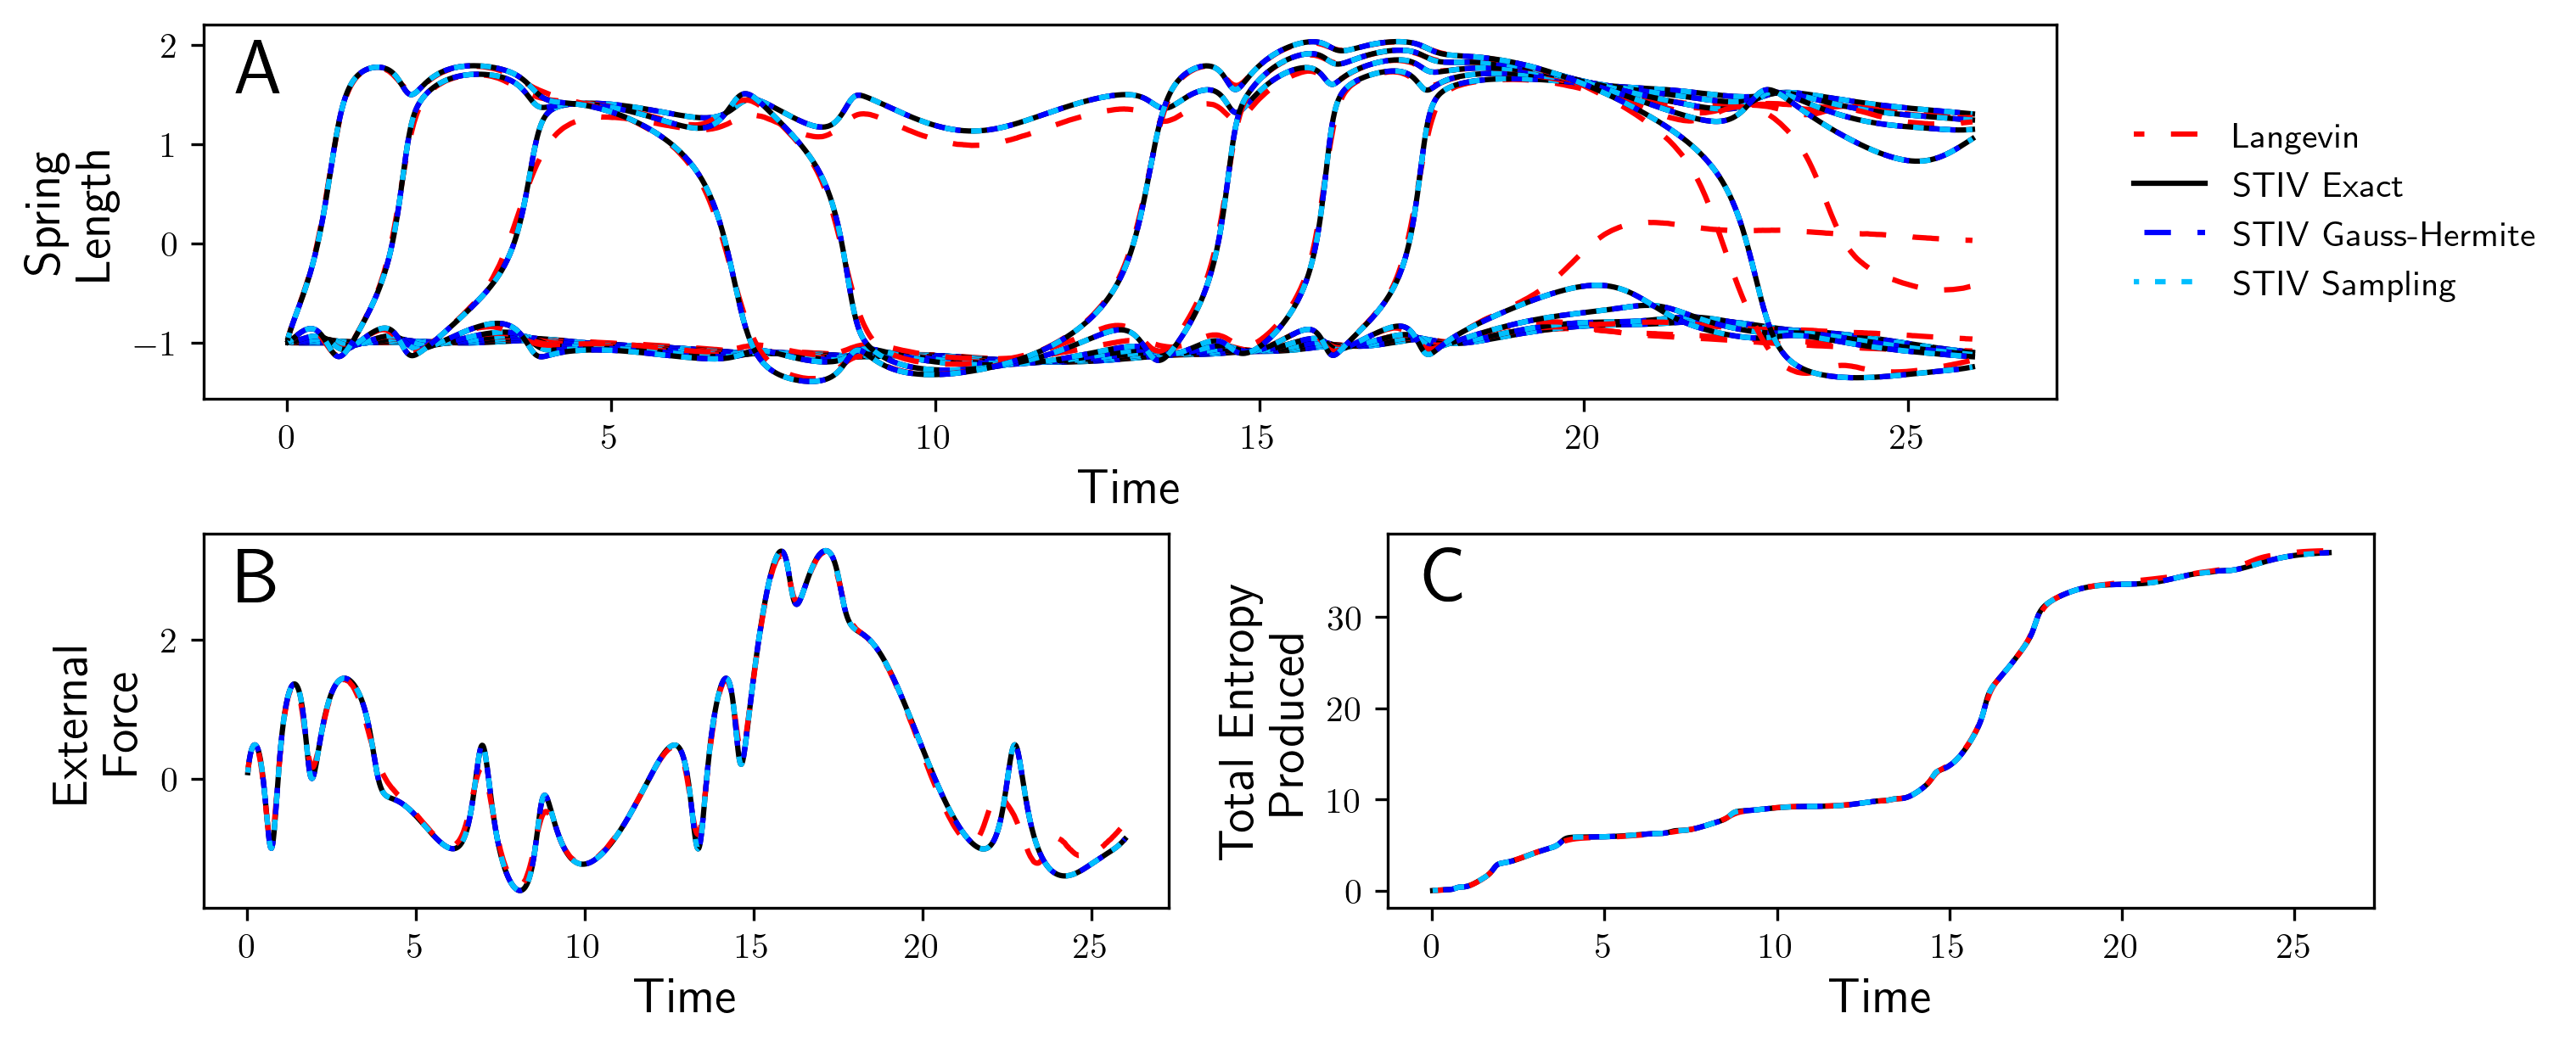

In [ ]:
import matplotlib.gridspec as gs
from matplotlib.lines import Line2D

def diff(m,l):
  em = np.zeros(m.shape[0]+2)
  em = em.at[1:-1].set(m)
  em = em.at[-1].set(l)
  return em[1:] - em[:-1]

alldms = [vmap(diff)(allms[i],sims[i].ell(allts[i])) for i in range(len(sims))]

fig = plt.figure(figsize = (10,4),dpi = 300,constrained_layout = True)
gsFig = fig.add_gridspec(2,8)
ax1 = fig.add_subplot(gsFig[0,:7])
ax2 = fig.add_subplot(gsFig[1,:4])
ax3 = fig.add_subplot(gsFig[1,4:])
axExtra = fig.add_subplot(gsFig[0,-1])
axExtra.set_axis_off()

ax = [ax1,ax2,ax3]

for i in range(alldms[0].shape[-1]):
    for j in range(len(sims)):
      ax[0].plot(allts[j],alldms[j][:,i],color = colors[j],linestyle = styles[j])
for j in range(len(sims)):
  #ax[1].plot(allts[j],allfExs[j],color = colors[j],linestyle = styles[j],label = labels[j],zorder = zorders[j])
  ax[1].plot(allts[j],allfExs[j],color = colors[j],linestyle = styles[j],zorder = zorders[j])
  ax[2].plot(allts[j],(allts[j][1] - allts[j][0])*(np.cumsum(allents[j]) - allents[j][0]),label = labels[j],color = colors[j],linestyle = styles[j],zorder = zorders[j])#,label = labels[j])
#ax[2].plot(tsPF,(tsPF[1] - tsPF[0])*(np.cumsum(entPFStrain) - entPFPhase[0]),linestyle = styles[-2],label = labels[-2],color = colors[-2],zorder = zorders[-2])
#ax[2].plot(tsPF,(tsPF[1] - tsPF[0])*(np.cumsum(entPFPhase) - entPFPhase[0]),linestyle = styles[-1],label = labels[-1],color = colors[-1],zorder = zorders[-1])

mlines = []
for j in range(len(labels)):
    mlines.append(Line2D([0],[0],linestyle = styles[j],label = labels[j],color = colors[j]))

axExtra.legend(mlines,labels,fontsize=  fs-4,loc = "center",bbox_to_anchor = (0.5,0.5),ncols = 1,frameon = False,columnspacing = .3)
#ax[2].legend(fontsize = fs-4,frameon = False)
#ax[2].set_ylim([-5,75])
for o in ax:
    o.set_xlabel("Time",fontsize = fs)
ax[0].set_ylabel("Spring\nLength",fontsize = fs)
ax[1].set_ylabel("External\nForce", fontsize = fs)
ax[2].set_ylabel("Total Entropy\nProduced",fontsize = fs)
#ax[0].set_title("Spring Lengths",fontsize = fs)
#ax[1].set_title("External Force",fontsize = fs)
#ax[2].set_title("Total Entropy Produced",fontsize = fs)
ax[0].text(0.03,0.87,"A",fontsize = fs+8,ha = "center",va = "center",transform = ax[0].transAxes)
ax[1].text(0.06,0.87,"B",fontsize = fs+8,ha = "center",va = "center",transform = ax[1].transAxes)
ax[2].text(0.06,0.87,"C",fontsize = fs+8,ha = "center",va = "center",transform = ax[2].transAxes)
#plt.tight_layout()
plt.savefig("Fig3.pdf")
plt.show()